# Evaluation

In [1]:
import torch
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from src import utils
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import os

plt.rcParams.update({'font.size': 8})

In [2]:
intensity_scales = [50, 100, 200, 300]
resolutions = [2, 5, 10, 20, 30, 40, 50]

## FISHFactor

In [3]:
df_list = []

for intensity_scale in intensity_scales:
    for cell in range(20):
        data = torch.load('data/intensity_scale_{}/cell_{}.pkl'.format(intensity_scale, cell))
        results = pickle.load(open('results/fishfactor/intensity_scale_{}/cell_{}/final/latents.pkl'.format(intensity_scale, cell), 'rb'))

        z_inferred = results['z'][0]
        z_inferred = torch.nan_to_num(z_inferred, 0)
        z_inferred /= z_inferred.flatten(start_dim=1).max(dim=-1)[0].view(data['n_factors'], 1, 1)
        z_data = data['z'][0]

        w_inferred = results['w']
        w_inferred /= w_inferred.max(dim=0)[0].view(1, data['n_factors'])
        w_data = data['w'][0]

        inds, _ = utils.optimal_assignment(z_data, z_inferred, 0)

        z_inferred = z_inferred[inds]
        w_inferred = w_inferred[:, inds]
        

        w_corr = pearsonr(w_data.flatten(), w_inferred.flatten())[0]
        z_corr = pearsonr(z_data.flatten(), z_inferred.flatten())[0]

        df_list.append(pd.DataFrame({
            'intensity_scale' : intensity_scale,
            'cell' : cell,
            'w_corr' : w_corr,
            'z_corr' : z_corr,
            'avg_n_molecules_gene' : data['coordinates'].shape[0] / data['n_genes'],
            'model' : 'FISHFactor',
            'resolution' : 70, # pseudo value
        }, index=[0]))

fishfactor_evaluation = pd.concat(df_list).reset_index(drop=True)

## NMF

In [4]:
df_list = []

for intensity_scale in intensity_scales:
    for cell in range(20):
        for resolution in resolutions:
            data = torch.load('data/intensity_scale_{}/cell_{}.pkl'.format(intensity_scale, cell))
            results = torch.load('results/nmf/intensity_scale_{}/cell_{}/resolution_{}.pkl'.format(intensity_scale, cell, resolution))

            z_inferred = results['z']
            z_inferred /= z_inferred.flatten(start_dim=1).max(dim=-1)[0].view(data['n_factors'], 1, 1)
            z_inferred = torch.nan_to_num(z_inferred, 0)
            z_data = data['z'][0]

            w_inferred = results['w']
            w_inferred /= np.clip(a=w_inferred.max(axis=0).reshape(1, data['n_factors']), a_min=0.001, a_max=1e4)
            w_inferred = np.nan_to_num(w_inferred, 0)
            w_data = data['w'][0]

            inds, _ = utils.optimal_assignment(z_data, z_inferred, 0)

            z_inferred = z_inferred[inds]
            w_inferred = w_inferred[:, inds]
            
            w_corr = pearsonr(w_data.flatten(), w_inferred.flatten())[0]
            z_corr = pearsonr(z_data.flatten(), z_inferred.flatten())[0]

            df_list.append(pd.DataFrame({
                'resolution' : resolution,
                'intensity_scale' : intensity_scale,
                'cell' : cell,
                'w_corr' : w_corr,
                'z_corr' : z_corr,
                'avg_n_molecules_gene' : data['coordinates'].shape[0] / data['n_genes'],
                'model' : 'NMF'
            }, index=[0]))

nmf_evaluation = pd.concat(df_list).reset_index(drop=True)

/data/florin/miniconda3/envs/env/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


## NSF

In [5]:
df_list = []

for intensity_scale in intensity_scales:
    for cell in range(20):
        for resolution in resolutions:
            if not os.path.isfile('results/nsf/intensity_scale_{}/cell_{}/resolution_{}.pkl'.format(intensity_scale, cell, resolution)):
                continue
            data = torch.load('data/intensity_scale_{}/cell_{}.pkl'.format(intensity_scale, cell))
            results = pickle.load(open('results/nsf/intensity_scale_{}/cell_{}/resolution_{}.pkl'.format(intensity_scale, cell, resolution), 'rb'))
            z_inferred = results['z']
            z_inferred /= z_inferred.flatten(start_dim=1).max(dim=-1)[0].view(data['n_factors'], 1, 1)
            z_inferred = torch.nan_to_num(z_inferred, 0)
            z_data = data['z'][0]

            w_inferred = results['w']
            w_inferred /= np.clip(a=w_inferred.max(axis=0).reshape(1, data['n_factors']), a_min=0.001, a_max=1e4)
            w_inferred = np.nan_to_num(w_inferred, 0)
            w_data = data['w'][0]

            inds, _ = utils.optimal_assignment(z_data, z_inferred, 0)

            z_inferred = z_inferred[inds]
            w_inferred = w_inferred[:, inds]
            
            w_corr = pearsonr(w_data.flatten(), w_inferred.flatten())[0]
            z_corr = pearsonr(z_data.flatten(), z_inferred.flatten())[0]

            df_list.append(pd.DataFrame({
                'resolution' : resolution,
                'intensity_scale' : intensity_scale,
                'cell' : cell,
                'w_corr' : w_corr,
                'z_corr' : z_corr,
                'avg_n_molecules_gene' : data['coordinates'].shape[0] / data['n_genes'],
                'model' : 'NSF',
            }, index=[0]))

nsf_evaluation = pd.concat(df_list).reset_index(drop=True)

## Plots

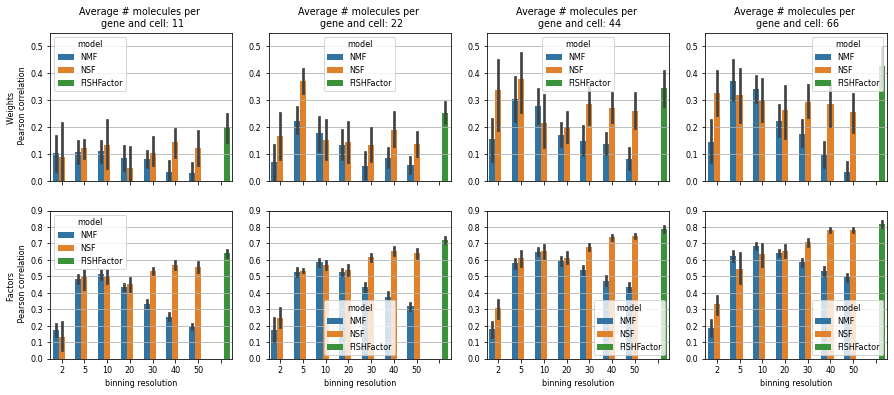

In [6]:
n_molecules = []

for intensity_scale in intensity_scales:
    for cell in range(20):
        data = torch.load('data/intensity_scale_{}/cell_{}.pkl'.format(intensity_scale, cell))
        for gene in range(data['n_genes']):
            n_molecules.append(pd.DataFrame({
                'intensity_scale' : intensity_scale,
                'cell' : cell,
                'gene' : gene,
                'counts' : data['coordinates'][data['coordinates'].gene==gene].shape[0]
            }, index=[0]))

n_molecules = pd.concat(n_molecules)

fig, axs = plt.subplots(2, 4, figsize=(15, 6), sharey=False, sharex=True)

for i, latent in enumerate(['w_corr', 'z_corr']):
    for j, intensity_scale in enumerate(intensity_scales):
        ax = axs[i, j]
        ax.grid()
        fishfactor_evaluation_subset = fishfactor_evaluation.query('intensity_scale=={}'.format(intensity_scale))
        nmf_evaluation_subset = nmf_evaluation.query('intensity_scale=={}'.format(intensity_scale))
        nsf_evaluation_subset = nsf_evaluation.query('intensity_scale=={}'.format(intensity_scale))
        evaluation_subset = pd.concat([nmf_evaluation_subset, nsf_evaluation_subset, fishfactor_evaluation_subset])
        
        evaluation_subset[['z_corr', 'w_corr']] = evaluation_subset[['z_corr', 'w_corr']]

        sns.barplot(x='resolution', y=latent, data=evaluation_subset, hue='model', ax=ax)
        ax.set_ylim(0, [0.55, 0.9][i])

        axs[i, j].set_xlabel('')
        axs[1, j].set_xlabel('binning resolution')

        axs[i, j].set_ylabel('')
        axs[i, 0].set_ylabel('{} \n Pearson correlation'.format(['Weights', 'Factors'][i]))

        average_n_molecules = n_molecules.groupby('intensity_scale').mean().counts.values.round()
        axs[0, j].set_title('Average # molecules per \n gene and cell: {}'.format(int(average_n_molecules[j])))

        axs[1, j].set_xticklabels(resolutions + [''])
plt.show()